In [10]:
# Downloading data
!pip install grad-cam
!pip install medmnist

In [11]:
import torch
import medmnist
import os
import datetime
import numpy as np
import cv2
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from PIL import Image
from medmnist import INFO
from torchvision import transforms, models
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, ClassifierOutputSoftmaxTarget ### modified for 1b.
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange ### modified for 1b.
from pytorch_grad_cam.metrics.road import ROADCombined ### modified for 1b.

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda:0


# Model and Data Loader

The code is based on the tutorial found: https://colab.research.google.com/drive/1QNit0tU1lW2mlDzx8XJRzSVn5p06Veop?usp=share_link

In [13]:
# defining parameters
model_name = "resnet50" # optional: choose different model for comparison (resnet101)
batch_size = 128
freeze = True
pretrained = True
trainable_layers = 2
data_flag = 'pathmnist' # optional: choose a different dataset for comparison (pathmnist)
info = INFO[data_flag]
num_classes = len(info["label"])
print(num_classes)
DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# prepare dataset
train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
valid_set = DataClass(split='val', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

image_shape = next(iter(train_loader))[0][0].cpu().numpy().shape
print(f"Image shape: {image_shape}")

# prepare model
if pretrained:
    weights = "DEFAULT"
if not pretrained:
    weights = None

# load model
model = getattr(models, model_name)(weights=weights)
module_names = [name for name, module in model.named_children()]
layer_names = [name for name in module_names if "layer" in name]
print(layer_names)
if freeze:
    trainable_layer_names = list()
    # freeze layers
    for param in model.parameters():
        param.requires_grad = False
    # unfreeze layers
    for param in model.fc.parameters():
        param.requires_grad = True
    for i, layer_name in enumerate(layer_names):
        if i + 1 > len(layer_names) - trainable_layers:
            trainable_layer_names.append(layer_name)
            for param in getattr(model, layer_name).parameters():
                param.requires_grad = True
    # replace fc layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.fc.reset_parameters()

print(f"Trainable layers: {', '.join(trainable_layer_names)}")

9
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Image shape: (3, 28, 28)
['layer1', 'layer2', 'layer3', 'layer4']
Trainable layers: layer3, layer4


# Benchmark Definitions with CAM

In [14]:
### START: Modifications for 1b.
def visualize_score(visualization, score, name, percentiles):
    font_scale=.4
    thickness=1 # px
    # visualization = cv2.putText(visualization, name, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), 1, cv2.LINE_AA)
    # visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), 1, cv2.LINE_AA)
    # visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), 1, cv2.LINE_AA)
    # visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{100*score:.5f}%", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), thickness, cv2.LINE_AA)
    return visualization
### END: Modifications for 1b.

def benchmark(data_loader, model, data_index=None, size_threshold=100):
    print(f"Grad-cam testing")

    model = model.to(device)
    input_tensor, targets = next(iter(data_loader))

    if data_index is None:
        data_index = np.random.randint(len(input_tensor)-1)

    input_tensor = input_tensor.to(device)[data_index]
    targets = targets[data_index].cpu().numpy()
    image = np.uint8(255 * input_tensor.cpu().numpy().transpose((1, 2, 0)))

    layer_names = [name for name, module in model.named_children() if "layer" in name]
    target_layers = [getattr(model, layer_names[-2])]

    methods = [ ("GradCAM", GradCAM(model=model, target_layers=target_layers)),
                ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
                ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
                ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
                ("RandomCAM", RandomCAM(model=model, target_layers=target_layers)) ]

    ### added for 1b.
    if len(image) < size_threshold:
        new_shape = (size_threshold, size_threshold)
        image_up = cv2.resize(image, new_shape, interpolation=4)
    images = [image_up]
    method_names = list()
    percentiles = [10, 50, 90] ### added for 1b.

    print(f"The confidence increase percent:") ### added for 1b.

    for name, method in methods:
        method_names.append(name)
        with method as cam_method:
            cam = cam_method(input_tensor=input_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(targets)])
            cam_on_image = show_cam_on_image(np.float32(image/255), cam[0, :], use_rgb=True)

            ### START: Modifications for 1b.

            # initialize/rename variables
            attributions = cam
            metric_targets = [ClassifierOutputSoftmaxTarget(targets)]
            visualization = cam_on_image

            # choose metric
            # cam_metric = CamMultImageConfidenceChange()
            cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])

            # calculate metric
            scores = cam_metric(input_tensor.unsqueeze(0), attributions, metric_targets, model)
            score = scores[0]

            # scale up before adding text
            if len(visualization) < size_threshold:
                new_shape = (size_threshold, size_threshold)
                visualization = cv2.resize(visualization, new_shape, interpolation=4)
            cam_on_image = visualize_score(visualization, score, name, percentiles)

            # output
            # print(f"{name}: {100*score:.5f}%")

            ### END: Modifications for 1b.

        images.append(cam_on_image)

    # if len(image) < size_threshold: ### commented out for 1b.
        # new_shape = (size_threshold * (len(methods) + 1), size_threshold)
        # images = cv2.resize(images, new_shape, interpolation=4)

    images = np.hstack(images)

    return Image.fromarray(images), method_names, data_index

# Defining training and testing functions

In [15]:
def train(device, model, train_loader, epochs, learning_rate):
    model.to(device)

    # some custom stuff
    saved_models = dict()
    data_index = None

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        losses = []
        valid_losses = []
        accuracies = []

        for i, (data, target) in enumerate(tqdm(train_loader, desc='Training-loop')):

            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            preds = torch.argmax(output.detach().cpu(), axis=1)
            labels = target.detach().cpu()
            acc = np.mean(preds.numpy() == labels.numpy())
            losses.append(loss.item())
            accuracies.append(acc)

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(valid_loader, desc='Validation-loop')):
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred, target)
                valid_losses.append(loss.item())

        images, cam_method_names, data_index = benchmark(train_loader, model, data_index)
        print("Raw, " + ", ".join(cam_method_names))
        display(images)
        saved_models[epoch] = model
        print(\
            f"Train Epoch: {epoch + 1:02d} | " +
            f"Loss: {np.mean(losses):.6f} | " +
            f"Validation loss: {np.mean(valid_losses):.6f} | " +
            f"Acc: {np.mean(accuracies) * 100:.6f}"
        )
    return model

In [16]:
def test(device, model, data_loader, mean=0.5432, std=0.2731):
    data_index = None

    model.eval()
    pred_list = []
    pred_labels = []
    correct = 0

    with torch.no_grad():
        for index, (images, target) in enumerate(tqdm(data_loader, desc='Test-loop')):
            images = images.to(device)
            target = target

            output = model(images).detach().cpu()
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_labels.append(labels)
            pred_list.append(preds)

    acc = correct / len(test_loader.dataset) * 100
    print(f"Test Accuracy: {acc:.6f}")

    # You should modify this section to reflect your CAM evaluation
    images, cam_method_names, data_index = benchmark(test_loader, model, data_index)
    print("Raw, " + ", ".join(cam_method_names))
    display(images)

    return np.concatenate(pred_list), np.concatenate(pred_labels)

In [17]:
def save_model(model, name=''):
    path = os.path.dirname(os.path.abspath(os.getcwd()))
    time = datetime.datetime.now().strftime('%d-%m-%Y-%H:%M:%S')
    path = os.path.join(path, 'Sheet_4', 'models', name + time + '.pth')

    torch.save(model, path)
    print('Model saved.')

def load_model(name=''):
    path = os.path.dirname(os.path.abspath(os.getcwd()))
    path = os.path.join(path,  'Sheet_4', 'models', name + '.pth')

    model = torch.load(path)

    print('Model loaded.')
    return model

# Evaluating the CAM methods, running the model

Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 24.37it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 93.60it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


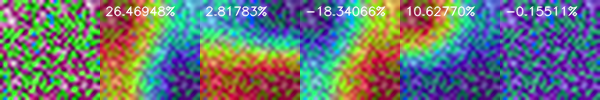

Train Epoch: 01 | Loss: 1.682549 | Validation loss: 1.105247 | Acc: 43.968987


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 22.53it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 96.35it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


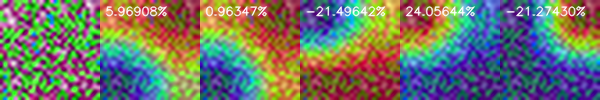

Train Epoch: 02 | Loss: 0.476252 | Validation loss: 0.345057 | Acc: 83.905214


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 22.64it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 94.92it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


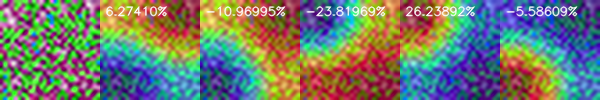

Train Epoch: 03 | Loss: 0.274481 | Validation loss: 0.295476 | Acc: 90.527714


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 22.44it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 95.61it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


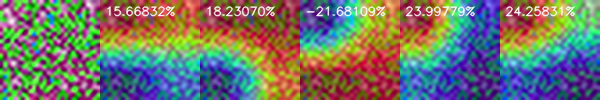

Train Epoch: 04 | Loss: 0.188862 | Validation loss: 0.280889 | Acc: 93.546919


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 22.13it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 92.62it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


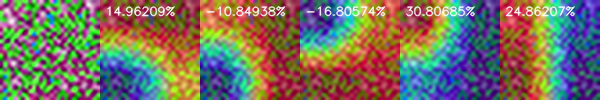

Train Epoch: 05 | Loss: 0.125531 | Validation loss: 0.282239 | Acc: 96.010520


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 22.05it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 89.78it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


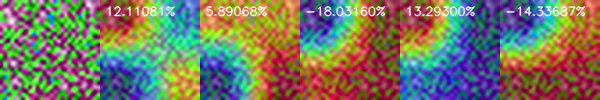

Train Epoch: 06 | Loss: 0.077141 | Validation loss: 0.298692 | Acc: 97.877086


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.95it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 85.94it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


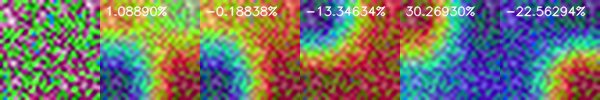

Train Epoch: 07 | Loss: 0.042225 | Validation loss: 0.330659 | Acc: 99.063388


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.50it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 91.25it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


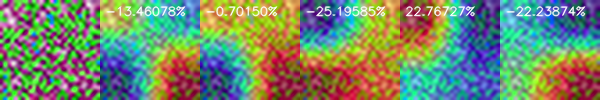

Train Epoch: 08 | Loss: 0.021208 | Validation loss: 0.378203 | Acc: 99.600497


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.70it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 91.41it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


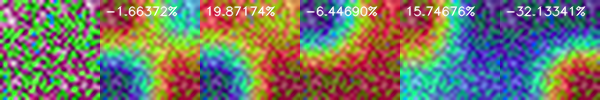

Train Epoch: 09 | Loss: 0.010095 | Validation loss: 0.434311 | Acc: 99.853516


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.29it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 90.20it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


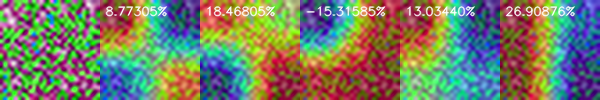

Train Epoch: 10 | Loss: 0.005137 | Validation loss: 0.493052 | Acc: 99.912331


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.62it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 89.51it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


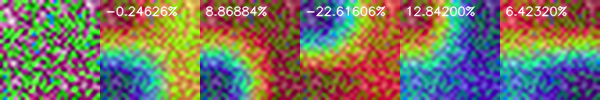

Train Epoch: 11 | Loss: 0.011050 | Validation loss: 0.432176 | Acc: 99.705922


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.41it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 87.61it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


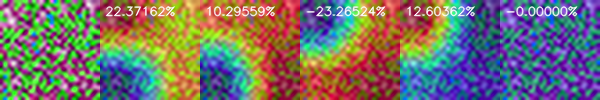

Train Epoch: 12 | Loss: 0.011882 | Validation loss: 0.483019 | Acc: 99.720348


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.19it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 91.69it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


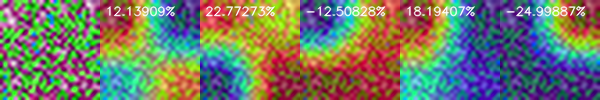

Train Epoch: 13 | Loss: 0.005479 | Validation loss: 0.508071 | Acc: 99.891246


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.37it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 86.51it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


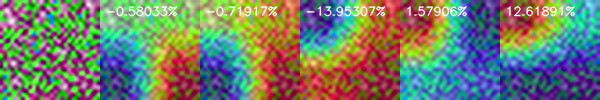

Train Epoch: 14 | Loss: 0.003598 | Validation loss: 0.537565 | Acc: 99.930087


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.27it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 91.61it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


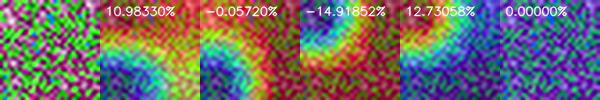

Train Epoch: 15 | Loss: 0.008381 | Validation loss: 0.495858 | Acc: 99.760298


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 20.99it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 90.30it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


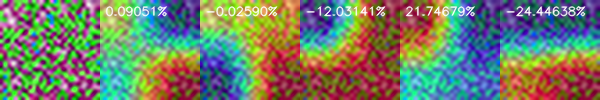

Train Epoch: 16 | Loss: 0.005883 | Validation loss: 0.513504 | Acc: 99.854625


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.56it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 88.92it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


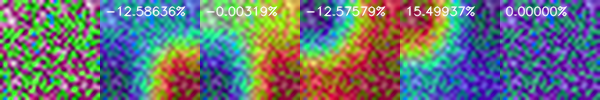

Train Epoch: 17 | Loss: 0.002754 | Validation loss: 0.559729 | Acc: 99.944513


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 21.17it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 82.65it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


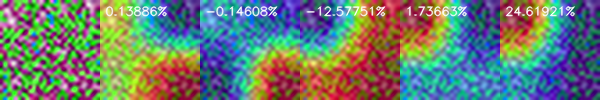

Train Epoch: 18 | Loss: 0.002277 | Validation loss: 0.590586 | Acc: 99.950062


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 19.87it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 71.88it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


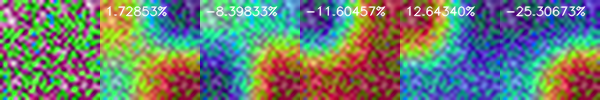

Train Epoch: 19 | Loss: 0.001674 | Validation loss: 0.619601 | Acc: 99.960050


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 16.47it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 83.65it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


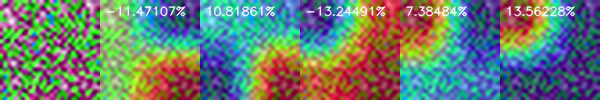

Train Epoch: 20 | Loss: 0.001357 | Validation loss: 0.647612 | Acc: 99.966708


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 18.73it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 80.38it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


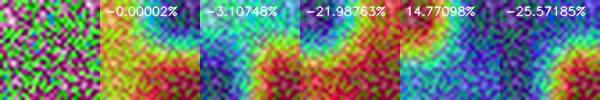

Train Epoch: 21 | Loss: 0.000937 | Validation loss: 0.668807 | Acc: 99.973366


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 20.85it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 86.27it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


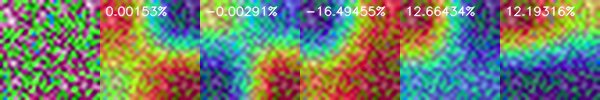

Train Epoch: 22 | Loss: 0.001795 | Validation loss: 0.695059 | Acc: 99.960050


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 20.54it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 88.11it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


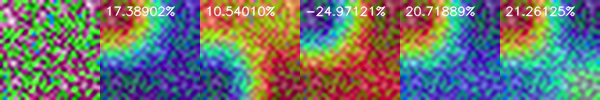

Train Epoch: 23 | Loss: 0.020381 | Validation loss: 0.495783 | Acc: 99.345259


Validation-loop: 100%|██████████| 79/79 [00:03<00:00, 20.69it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 85.22it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


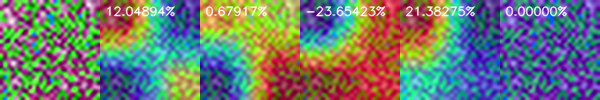

Train Epoch: 24 | Loss: 0.004988 | Validation loss: 0.522016 | Acc: 99.859064


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 19.73it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 84.14it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


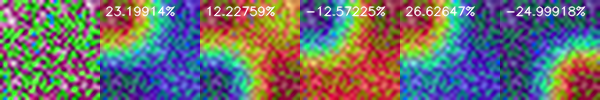

Train Epoch: 25 | Loss: 0.002596 | Validation loss: 0.551663 | Acc: 99.932306


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 18.99it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 85.10it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


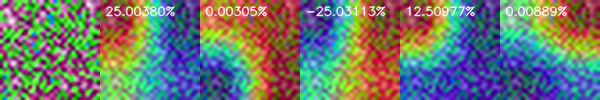

Train Epoch: 26 | Loss: 0.001583 | Validation loss: 0.574594 | Acc: 99.958940


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 16.77it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 85.31it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


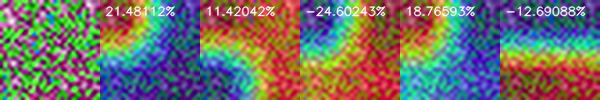

Train Epoch: 27 | Loss: 0.001212 | Validation loss: 0.590643 | Acc: 99.970037


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 17.55it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 83.94it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


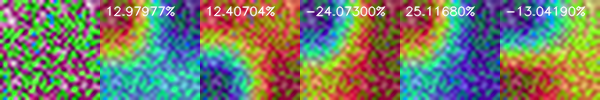

Train Epoch: 28 | Loss: 0.000997 | Validation loss: 0.624277 | Acc: 99.968928


Validation-loop: 100%|██████████| 79/79 [00:05<00:00, 15.62it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 84.38it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


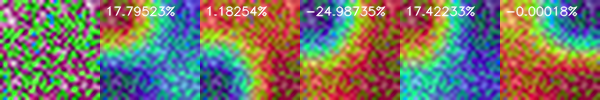

Train Epoch: 29 | Loss: 0.001435 | Validation loss: 0.646994 | Acc: 99.961159


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 16.33it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 79.30it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


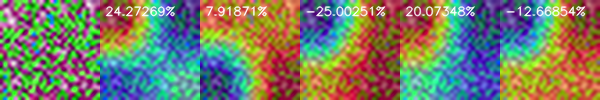

Train Epoch: 30 | Loss: 0.000748 | Validation loss: 0.667500 | Acc: 99.976696


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 17.16it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 68.88it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


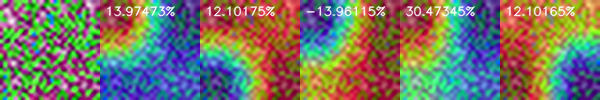

Train Epoch: 31 | Loss: 0.000510 | Validation loss: 0.690720 | Acc: 99.982244


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 17.57it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 64.72it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


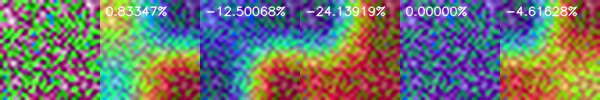

Train Epoch: 32 | Loss: 0.019967 | Validation loss: 0.469653 | Acc: 99.351918


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 19.15it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 80.14it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


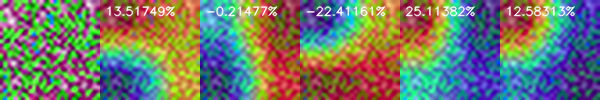

Train Epoch: 33 | Loss: 0.003490 | Validation loss: 0.537729 | Acc: 99.905673


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 18.92it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 80.56it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


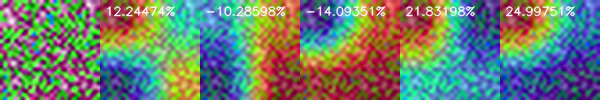

Train Epoch: 34 | Loss: 0.001304 | Validation loss: 0.569903 | Acc: 99.973366


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 17.95it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 79.23it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


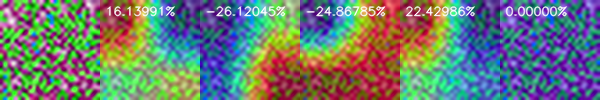

Train Epoch: 35 | Loss: 0.000486 | Validation loss: 0.592565 | Acc: 99.984464


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 16.03it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 82.00it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


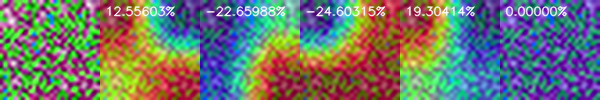

Train Epoch: 36 | Loss: 0.000369 | Validation loss: 0.615740 | Acc: 99.986683


Validation-loop: 100%|██████████| 79/79 [00:05<00:00, 15.32it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 76.24it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


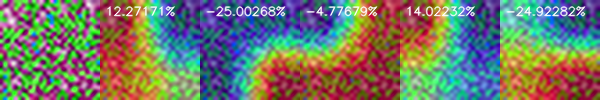

Train Epoch: 37 | Loss: 0.000711 | Validation loss: 0.633425 | Acc: 99.975586


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 16.59it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 62.21it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


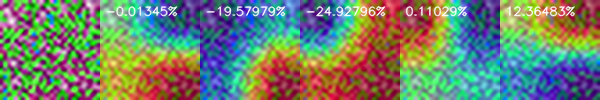

Train Epoch: 38 | Loss: 0.001233 | Validation loss: 0.657430 | Acc: 99.971147


Validation-loop: 100%|██████████| 79/79 [00:05<00:00, 15.60it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 59.96it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


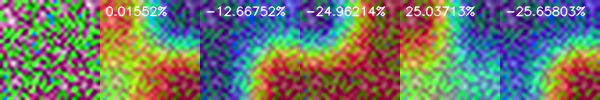

Train Epoch: 39 | Loss: 0.000667 | Validation loss: 0.676205 | Acc: 99.977805


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 18.14it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 65.34it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


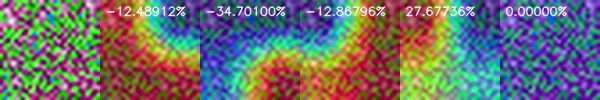

Train Epoch: 40 | Loss: 0.000597 | Validation loss: 0.698906 | Acc: 99.986683


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 17.85it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 80.16it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


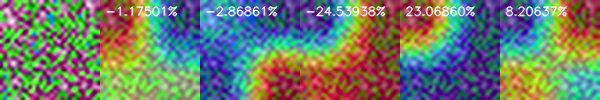

Train Epoch: 41 | Loss: 0.000451 | Validation loss: 0.724720 | Acc: 99.986683


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 16.28it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 81.39it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


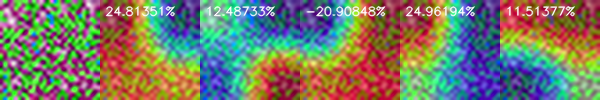

Train Epoch: 42 | Loss: 0.000783 | Validation loss: 0.746740 | Acc: 99.978915


Validation-loop: 100%|██████████| 79/79 [00:05<00:00, 15.23it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 75.46it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


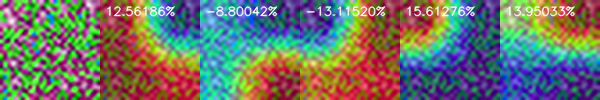

Train Epoch: 43 | Loss: 0.000861 | Validation loss: 0.770795 | Acc: 99.982244


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 17.06it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 58.36it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


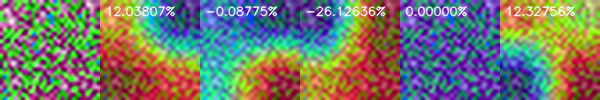

Train Epoch: 44 | Loss: 0.000207 | Validation loss: 0.789932 | Acc: 99.995561


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 18.41it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 67.20it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


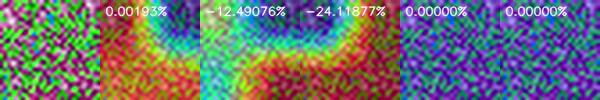

Train Epoch: 45 | Loss: 0.000165 | Validation loss: 0.813756 | Acc: 99.993342


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 17.98it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 79.07it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


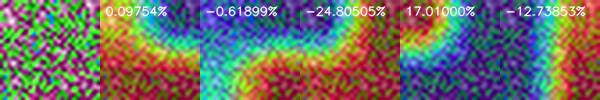

Train Epoch: 46 | Loss: 0.000165 | Validation loss: 0.816162 | Acc: 99.993342


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 17.65it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 75.11it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


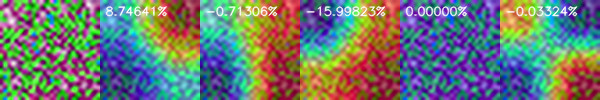

Train Epoch: 47 | Loss: 0.018775 | Validation loss: 0.484272 | Acc: 99.424050


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 16.88it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 77.63it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


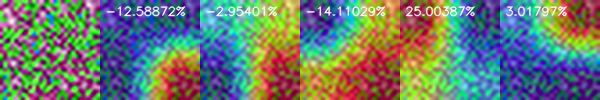

Train Epoch: 48 | Loss: 0.006156 | Validation loss: 0.553311 | Acc: 99.803578


Validation-loop: 100%|██████████| 79/79 [00:05<00:00, 14.52it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 58.34it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


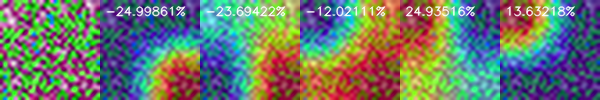

Train Epoch: 49 | Loss: 0.001463 | Validation loss: 0.576497 | Acc: 99.963379


Validation-loop: 100%|██████████| 79/79 [00:04<00:00, 16.06it/s]


Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 68.33it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


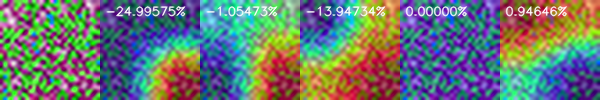

Train Epoch: 50 | Loss: 0.000445 | Validation loss: 0.604751 | Acc: 99.991122


In [18]:
# Define training parameters
epochs = 50
learning_rate = 1e-5

# train the model
model_trained = train(device, model, train_loader, epochs, learning_rate)

Test-loop: 100%|██████████| 57/57 [00:03<00:00, 18.48it/s]


Test Accuracy: 87.910864
Grad-cam testing
The confidence increase percent:


100%|██████████| 32/32 [00:00<00:00, 94.72it/s]


Raw, GradCAM, GradCAM++, EigenGradCAM, AblationCAM, RandomCAM


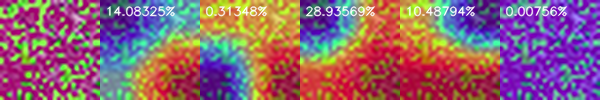

In [19]:
# test the model
predictions, labels = test(device, model, test_loader)